# Xarray-spatial User Guide:
### Surface tools
-----

These provide an essential set of operations on a 3 dimensional surface (or "terrain") that can help identify specific features or patterns that are not apparent in the static data. It accepts and returns multidimensional xarray DataArrays.

The set of surface tools includes:

[Hillshade](#Hillshade): Creates a shaded relief from a surface raster by considering the illumination source angle and shadows.

[Slope](#Slope): Identifies the slope from each cell of a raster.

[Curvature](#Curvature): Calculates the curvature of a raster surface.

[Aspect](#Aspect): Derives the aspect from each cell of a raster surface.

[Viewshed](#Viewshed): Determines visible locations in the input raster surface from a viewpoint with some optional observer features.

-----------


### Getting Started:

### Prepare your packages:
We'll need the basic Numpy and Pandas, as well as datashader,  
a data rasterization package highly compatible with Xarray-spatial.  
Along with the base package, we'll import several nested functions (shade, stack...)  
including Elevation, which we'll use below.

In [146]:
import numpy as np
import pandas as pd

import datashader as ds

from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

### Import Xarray-spatial

In [147]:
import xrspatial

## Generate A Terrain Surface DataArray:

First, we'll set up a base raster to experiment with by using some datashader functions. The Canvas object provides a starting point in generating a new raster.

Now, you can use generate_terrain to generate a random terrain surface raster.

Using the datashader shade function from above provides a quick visualization, using a simle black-to-white colormap.

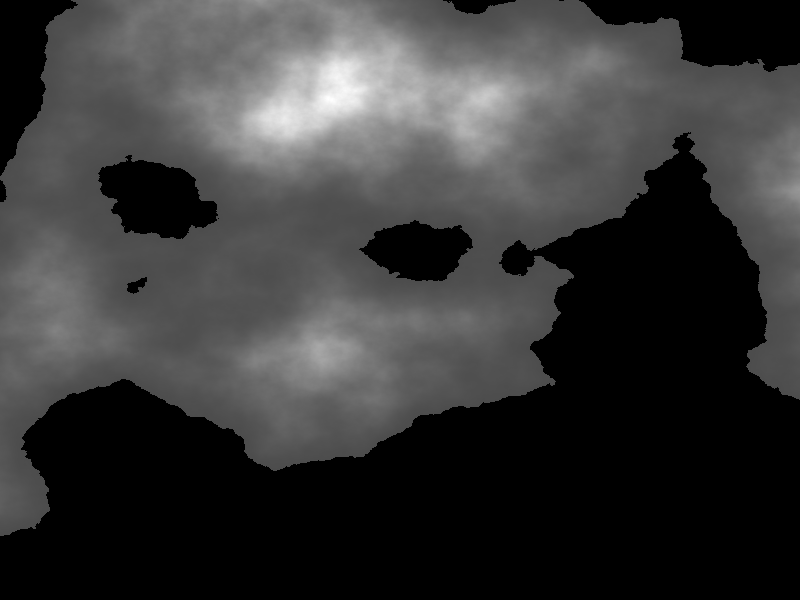

In [148]:
from xrspatial import generate_terrain

W = 800
H = 600

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20e6, 20e6), y_range=(-20e6, 20e6))
terrain = generate_terrain(canvas=cvs)

shade(terrain, cmap=['black', 'white'], how='linear')

The grayscale image above shows the elevation, scaled linearly in black-to-white color intensity (with the large black areas indicating low elevation). 

We can see some detail here, but a different colormap might give a more meaningful representation. Try the Elevation colormap we imported above:

/Users/ls/anaconda3/envs/xrs/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


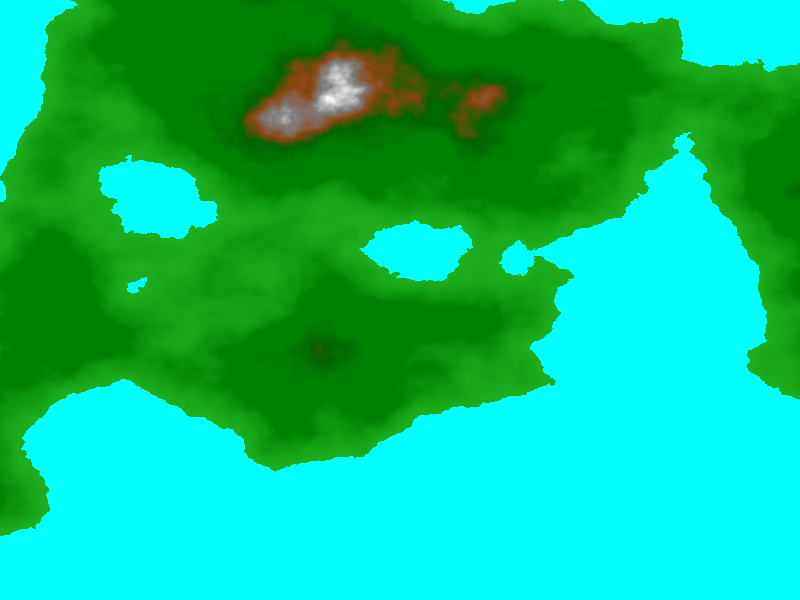

In [149]:
shade(terrain, cmap=Elevation, how='linear')

Notice how the color mapping range (light blue to green to brown to gray)  
shows low areas as water and high elevations as rocky moutaintop. Also notice the level  
of detail in the randomly generated terrain. Further customization parameters are available  
as well in the generate_terrain function, if needed.

## Hillshade

[Hillshade](https://en.wikipedia.org/wiki/Terrain_cartography) is a technique used to visualize terrain as shaded relief, illuminating it with a simulated light source. The illumination value for each cell is determined by its orientation to the light source, which can be determined from the slope and aspect variable calculations.

We can apply hillshade to our generated terrain.  
Then, we can use the datashader shade function again  
for easy visualization.

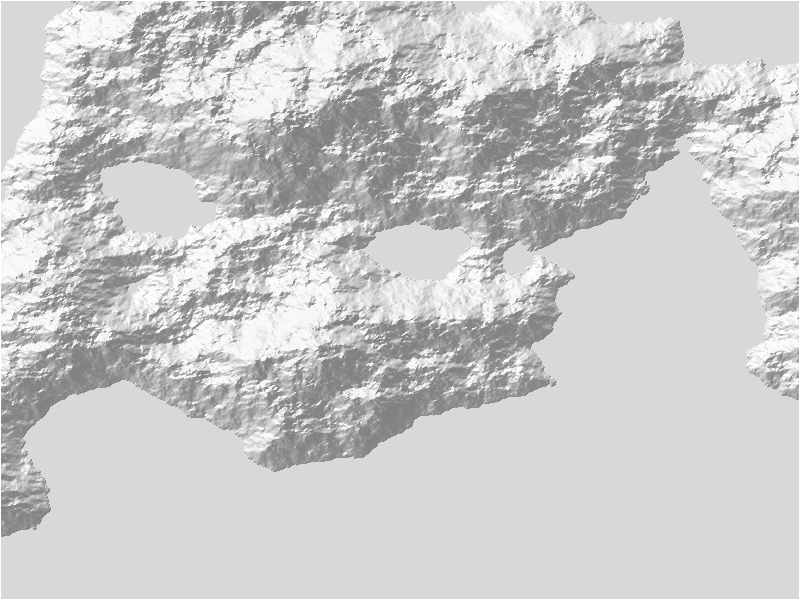

In [150]:
from xrspatial import hillshade

illuminated = hillshade(terrain)

hillshade_gray_white = shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear')
hillshade_gray_white

Applying hillshade reveals a lot of detail in the 3D shape of the terrain.

To add even more detail, we can add the Elevation colormapped terrain from earlier, and  
we can combine it with the hillshade terrain using datashader's stack function.

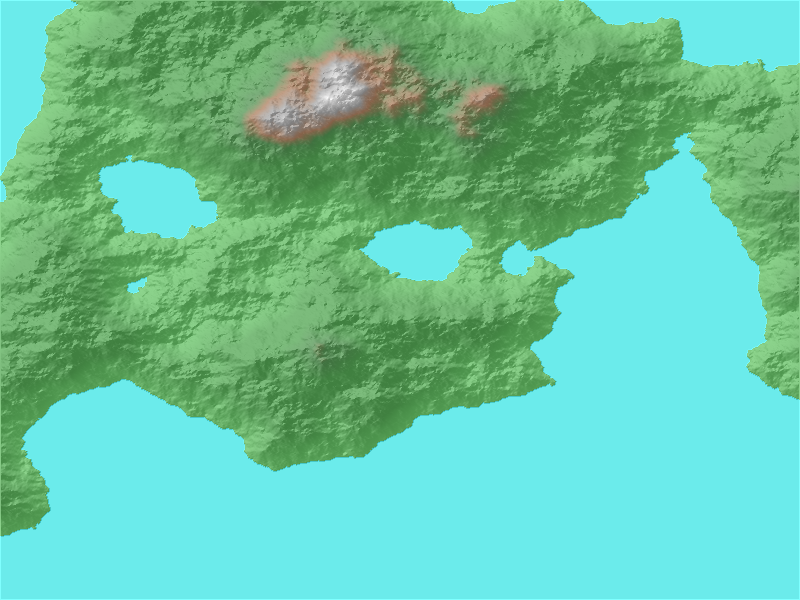

In [151]:
terrain_elevation = shade(terrain, cmap=Elevation, alpha=128, how='linear')
stack(hillshade_gray_white, terrain_elevation)

Comparing this image with the original plain terrain one shows how much detail can be gained  
with hillshade. 

## Slope
[Slope](https://en.wikipedia.org/wiki/Slope) is the inclination of a surface. 
In geography, *slope* is the amount of change in the elevation of a terrain relative to  
its surroundings.

Xarray-spatial's slope function gives slope in degrees.
Because Xarray-spatial integrates seamlessly with Xarray and Numpy, we can apply standard Numpy  filters. For example, we can highlight  
only slopes in the [avalanche risk](http://wenatcheeoutdoors.org/2016/04/07/avalanche-abcs-for-snowshoers/) range of 25 - 50 degrees. (Note the use of risky.data since these are DataArrays).
Stacking the resulting raster with the hillshaded and plain terrain ones from above  
gives an image with areas of avalanche risk neatly highlighted.

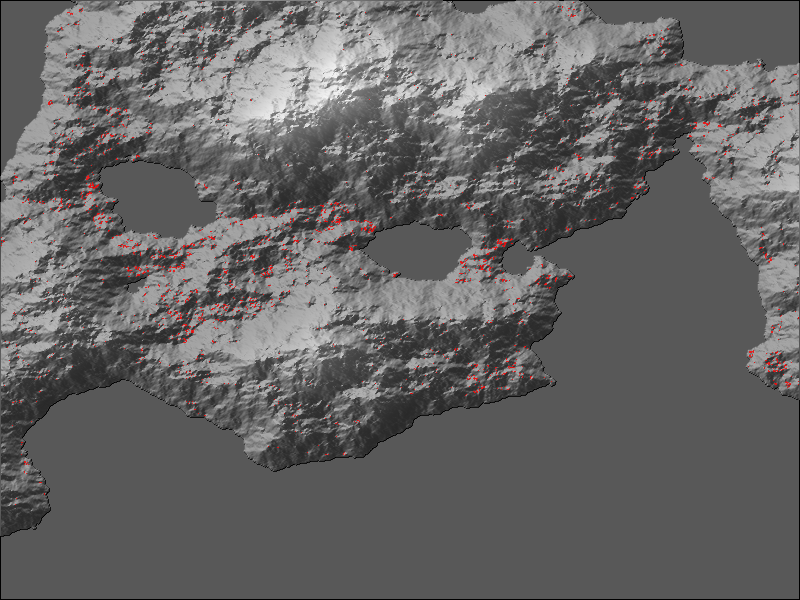

In [152]:
from xrspatial import slope

risky = slope(terrain)
risky.data = np.where(np.logical_and(risky.data > 25, risky.data < 50), 1, np.nan)

stack(shade(terrain,     cmap=['black', 'white'], how='linear'),
      shade(illuminated, cmap=['black', 'white'], how='linear', alpha=128),
      shade(risky,       cmap='red',              how='linear', alpha=200))

## Curvature
[Curvature](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/curvature.htm) is the second derivative of a surface's elevation, or the *slope-of-the-slope*; in other words, how fast the slope is increasing or decreasing as we move along a surface.
- A positive curvature means the surface is curving up (upwardly convex) at that cell. 
- A negative curvature means the surface is curving down (downwardly convex) at that cell. 
- A curvature of 0 means the surface is striaght and constant in whatever angle it's sloped towards.

The Xarray-spatial curvature function returns a raster in units one hundredth (1/100) of the z-factor, or scaling factor (which you can set explicitly in generate _terrain as "zfactor").  
Reasonably expected values in the curvature raster for a hilly area (moderate relief) would be between -0.5 and 0.5; while for steep, rugged mountains (extreme relief), these can range as far as -4 and 4. For certain raster surfaces it is possible to go even higher than that.

Let's generate a terrain with an appropriate z-factor and apply the curvature function to it. Then, we can apply some Numpy filtering (remember, we have access to all those functions) to highlight steeper and gentler upward curves in the slopes.
Stacking these with the hillshaded and plain terrains gives us a fuller picture of the slopes.

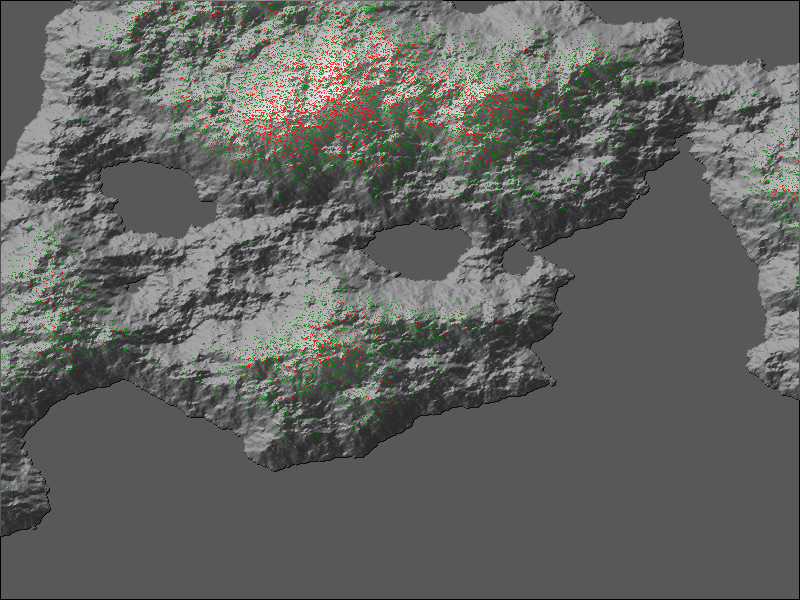

In [153]:
from xrspatial import curvature

terrain_z_one = generate_terrain(canvas=cvs, zfactor=1)
curv = curvature(terrain_z_one)
curv_hi, curv_low = curv.copy(), curv.copy()
curv_hi.data = np.where(np.logical_and(curv_hi.data > 1, curv_hi.data < 4), 1, np.nan)
curv_low.data = np.where(np.logical_and(curv_low.data > 0.5, curv_low.data < 1), 1, np.nan)

stack(shade(terrain,     cmap=['black', 'white'], how='linear'),
      shade(illuminated, cmap=['black', 'white'], how='linear', alpha=128),
      shade(curv_hi,        cmap='red',           how='log',    alpha=200),
      shade(curv_low,        cmap='green',        how='log',    alpha=200))

## Aspect

[Aspect](https://en.wikipedia.org/wiki/Aspect_(geography)) is the orientation of a slope, measured clockwise in degrees from 0 to 360, where 0 is north-facing, 90 is east-facing, 180 is south-facing, and 270 is west-facing.

The Xarray-spatial aspect function return the aspect in degrees for each cell in an elevation terrain.

We can apply aspect to our terrain, then use Numpy to filter out only slope facing close to North, then stack the resulting raster with the hillshaded and plain terrains.
(Note: the printout images are from a North point-of-view.)

/Users/ls/anaconda3/envs/xrs/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


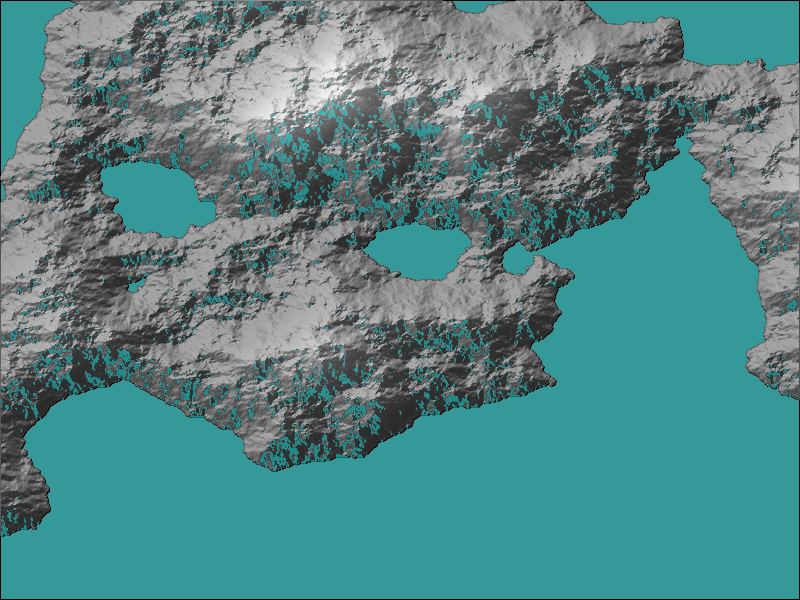

In [154]:
from xrspatial import aspect

north_faces = aspect(terrain)
north_faces.data = np.where(np.logical_or(north_faces.data > 350 ,
                                          north_faces.data < 10), 1, np.nan)

stack(shade(terrain,     cmap=['black', 'white'], how='linear'),
      shade(illuminated, cmap=['black', 'white'], how='linear', alpha=128),
      shade(north_faces, cmap=['aqua'],           how='linear', alpha=100))

## Viewshed

The Xarray-spatial viewshed function operates on a DataArray aggregate (such as our terrain from above) to calculate the viewshed (all cells that are visible from a given viewpoint - i.e., observer location.  

The visibility model is as follows: Two cells are visible to each other if the line of sight that connects their centers is not blocked at any point by another part of the terrain. If the line of sight does not pass through the cell center, elevation is determined using bilinear interpolation. 

#### A Simple Viewshed Example

To illustrate viewshed, here's an example usage in a simple case:

##### Setup
Just to set up:
- We'll use datashader to set up a Canvas object.
- We'll set up an x, y DataFrame with a normal distribution spread of x and y around a point.
- Finally, we'll aggregate the points by inputting the DataFrame in the points method of the Canvas.
- As one final step, we'll also aggregate the x and y coordinate location of the observer by putting it in a DataFrame and then using the canvas.points method in the same way.
Note: this is a few extra steps, and we were able to skip this for generate_terrain because it took care of it behind the scenes. In any case, now we're all set with aggregate surface rasters to put into the viewshed function.

In [155]:
from xrspatial import viewshed
import xarray as xr
pd.set_option('display.max_rows', 6, 'display.max_columns', 6)
xr.set_options(display_max_rows=6, display_width=200)
np.set_printoptions(threshold=6, edgeitems=3)
OBSERVER_X = -12.5
OBSERVER_Y = 10

canvas = ds.Canvas(plot_width=W, plot_height=H,
                   x_range=(-20, 20), y_range=(-20, 20))

normal_df = pd.DataFrame({
   'x': np.random.normal(.5, 1, 10000000),
   'y': np.random.normal(.5, 1, 10000000)
})
normal_agg = canvas.points(normal_df, 'x', 'y')
normal_agg.values = normal_agg.values.astype("float64")
normal_shaded = shade(normal_agg)

observer_df = pd.DataFrame({'x': [OBSERVER_X], 'y': [OBSERVER_Y]})
observer_agg = canvas.points(observer_df, 'x', 'y')
type(normal_agg), normal_agg.shape, type(observer_agg), observer_agg.shape

(xarray.core.dataarray.DataArray,
 (600, 800),
 xarray.core.dataarray.DataArray,
 (600, 800))

Now, to do a quick visualization of our rasters:
We can apply hillshade to the normal distribution raster and visualize with shade,  
visualize the observer viewpoint with shade (and use dynspread for zooming),  
and then stack the two with stack.

/Users/ls/anaconda3/envs/xrs/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


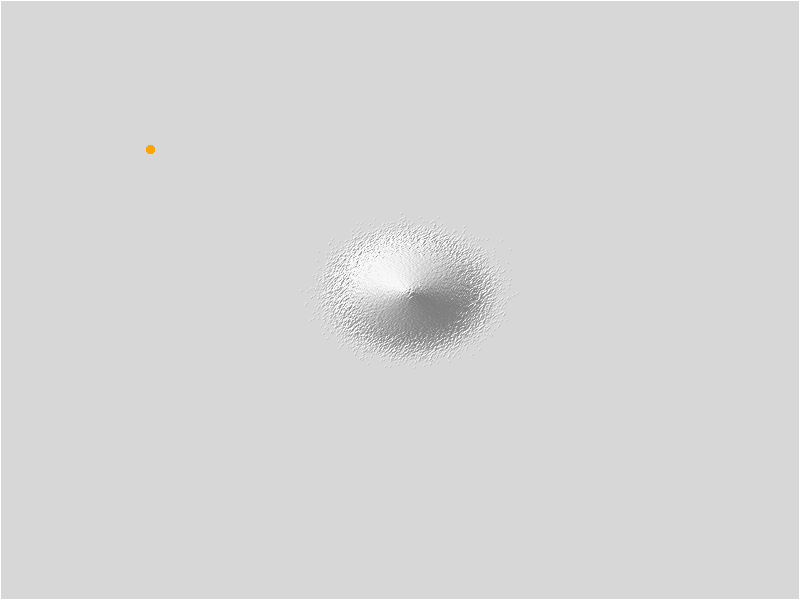

In [156]:
normal_illuminated = hillshade(normal_agg)
normal_illuminated_shaded = shade(normal_illuminated, cmap=['black', 'white'], 
                                  alpha=128, how='linear')

observer_shaded = dynspread(shade(observer_agg, cmap=['orange']),
                            threshold=1, max_px=4)

stack(normal_illuminated_shaded, observer_shaded)

Note the normal distribution spread of x,y points towards the right of the image and the orange dot for the observer towards the upper left.

##### Apply Viewshed

We can apply viewshed to the normal_agg, then visualize it and stack it with the hillshade and observer rasters.

CPU times: user 4.16 s, sys: 237 ms, total: 4.4 s
Wall time: 6.25 s


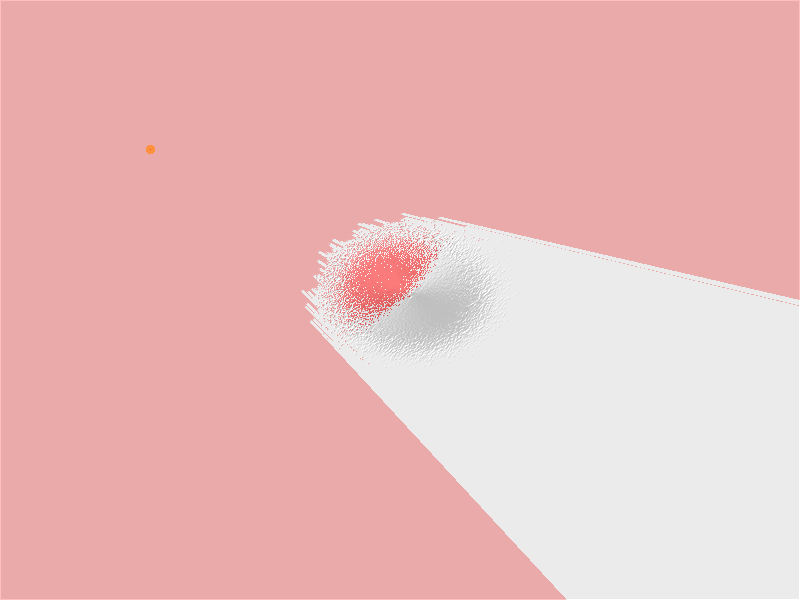

In [157]:
# Will take some time to run...
%time view = viewshed(normal_agg, x=OBSERVER_X, y=OBSERVER_Y)

view_shaded = shade(view, cmap=['white', 'red'], alpha=128, how='linear')

stack(normal_illuminated_shaded, observer_shaded, view_shaded)                         

As you can see, the image highlights in red all points visible from the observer location marked with the orange dot. As one might expect, the areas behind the normal distribution mountain are block from the viewer.

#### Viewshed on Terrain
Now we can try using viewshed on our more complicated terrain.

##### Setup:
Let's set up a new terrain with a wider x and y range, visualize it first without, then with hillshade, then add the obsserver shade and stack them all together.
Then, we can set an observed right in the center at (x, y) = (0, 0).

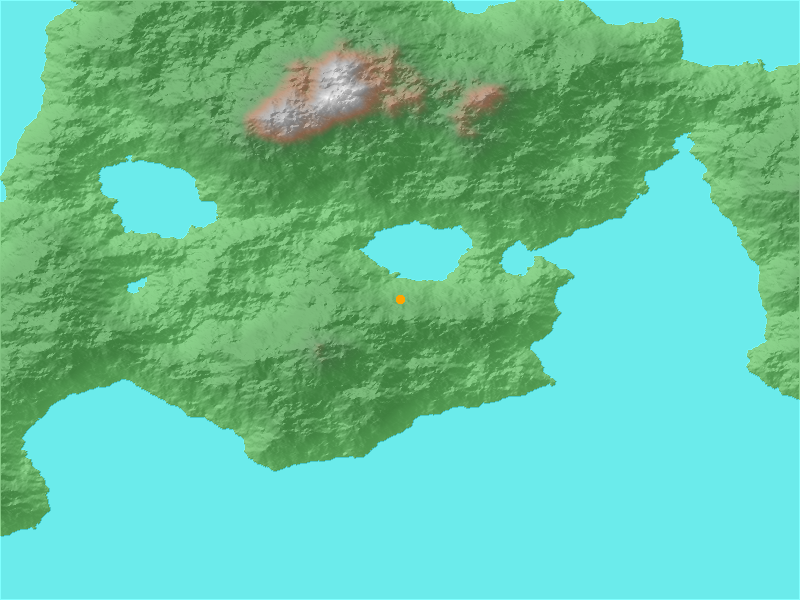

In [158]:
cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20e6, 20e6), y_range=(-20e6, 20e6))
terrain = generate_terrain(canvas=cvs)

terrain_shaded = shade(terrain, cmap=Elevation, alpha=128, how='linear')

illuminated = hillshade(terrain)

OBSERVER_X = 0.0
OBSERVER_Y = 0.0

observer_df = pd.DataFrame({'x': [OBSERVER_X],'y': [OBSERVER_Y]})
observer_agg = cvs.points(observer_df, 'x', 'y')
observer_shaded = dynspread(shade(observer_agg, cmap=['orange']),
                            threshold=1, max_px=4)

stack(shade(illuminated, cmap=['black', 'white'], alpha=128, how='linear'),
      terrain_shaded,
      observer_shaded)

##### Apply Viewshed:
Now we can apply viewshed to our terrain, then shade and stack it with all the rasters from above.
- Note the use of the observer_elev argument, this sets the viepoint to an observer at the given height above the surface.

In [1]:
%time view = viewshed(terrain, x=OBSERVER_X, y=OBSERVER_Y, observer_elev=100)

view_shaded = shade(view, cmap='fuchsia', how='linear')

stack(shade(illuminated, cmap=['black', 'white'], alpha=128, how='linear'),
      terrain_shaded,
      view_shaded,
      observer_shaded)

NameError: name 'viewshed' is not defined

In [ ]:
The fuchsia areas are those visible to an observer of the given height at the indicated orange location.




### References
- An overview of the Surface toolset: https://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/an-overview-of-the-surface-tools.htm
- Burrough, P. A., and McDonell, R. A., 1998. Principles of Geographical Information Systems (Oxford University Press, New York), p. 406.
- Making Maps with Noise Functions: https://www.redblobgames.com/maps/terrain-from-noise/
- How Aspect Works: http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-aspect-works.htm#ESRI_SECTION1_4198691F8852475A9F4BC71246579FAA